In [6]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import lstm, time 
import numpy as np
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Using TensorFlow backend.


In [7]:
dataset = read_csv('pierna.csv', header=0, index_col=0)
values = dataset.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])


In [8]:
# ensure all data is float
values = values.astype('float32')


In [9]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True) 

In [10]:
print(values.shape)

(132, 3)


In [39]:
# split into train and test sets
values = reframed.values
n_train_hours = 132-24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(values.shape,train.shape,test.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))



(131, 4) (108, 4) (23, 4)


In [40]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Activation('tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=200, batch_size=92,validation_data=(test_X, test_y),shuffle=False)



Train on 108 samples, validate on 23 samples
Epoch 1/200
108/108 [==============================] - 0s - loss: 0.1125 - val_loss: 0.3152
Epoch 2/200
108/108 [==============================] - 0s - loss: 0.1018 - val_loss: 0.3032
Epoch 3/200
108/108 [==============================] - 0s - loss: 0.0924 - val_loss: 0.2911
Epoch 4/200
108/108 [==============================] - 0s - loss: 0.0802 - val_loss: 0.2791
Epoch 5/200
108/108 [==============================] - 0s - loss: 0.0726 - val_loss: 0.2671
Epoch 6/200
108/108 [==============================] - 0s - loss: 0.0644 - val_loss: 0.2554
Epoch 7/200
108/108 [==============================] - 0s - loss: 0.0611 - val_loss: 0.2442
Epoch 8/200
108/108 [==============================] - 0s - loss: 0.0595 - val_loss: 0.2336
Epoch 9/200
108/108 [==============================] - 0s - loss: 0.0571 - val_loss: 0.2236
Epoch 10/200
108/108 [==============================] - 0s - loss: 0.0547 - val_loss: 0.2147
Epoch 11/200
108/108 [============

108/108 [==============================] - 0s - loss: 0.0571 - val_loss: 0.1330
Epoch 176/200
108/108 [==============================] - 0s - loss: 0.0592 - val_loss: 0.1325
Epoch 177/200
108/108 [==============================] - 0s - loss: 0.0589 - val_loss: 0.1319
Epoch 178/200
108/108 [==============================] - 0s - loss: 0.0627 - val_loss: 0.1312
Epoch 179/200
108/108 [==============================] - 0s - loss: 0.0586 - val_loss: 0.1306
Epoch 180/200
108/108 [==============================] - 0s - loss: 0.0625 - val_loss: 0.1301
Epoch 181/200
108/108 [==============================] - 0s - loss: 0.0609 - val_loss: 0.1299
Epoch 182/200
108/108 [==============================] - 0s - loss: 0.0604 - val_loss: 0.1298
Epoch 183/200
108/108 [==============================] - 0s - loss: 0.0592 - val_loss: 0.1296
Epoch 184/200
108/108 [==============================] - 0s - loss: 0.0615 - val_loss: 0.1296
Epoch 185/200
108/108 [==============================] - 0s - loss: 0.0603

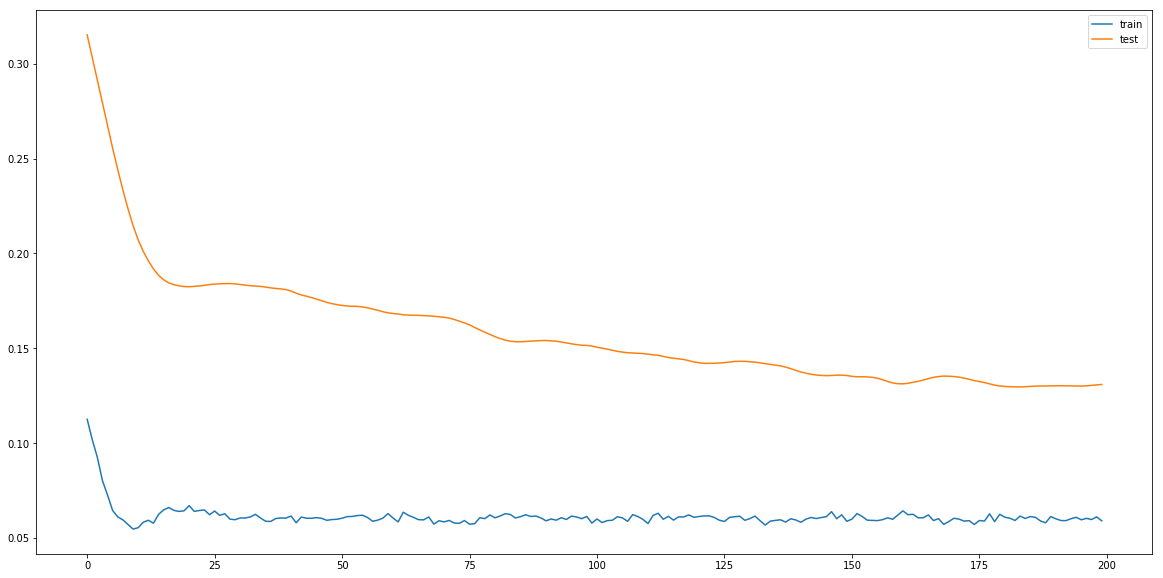

In [41]:
pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [42]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [43]:
print(test_X.shape)
print(yhat.shape)

(23, 3)
(23, 1)


In [44]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[1:,0]


In [45]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:22,0]

In [46]:
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r=pearsonr(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test R %.3f' %r[0])

Test RMSE: 390553.969
Test R 0.973


In [47]:
pyplot.figure(figsize=(20,10))
pyplot.plot(inv_y, label='y')
pyplot.plot(inv_yhat, label='yhat')
pyplot.legend()

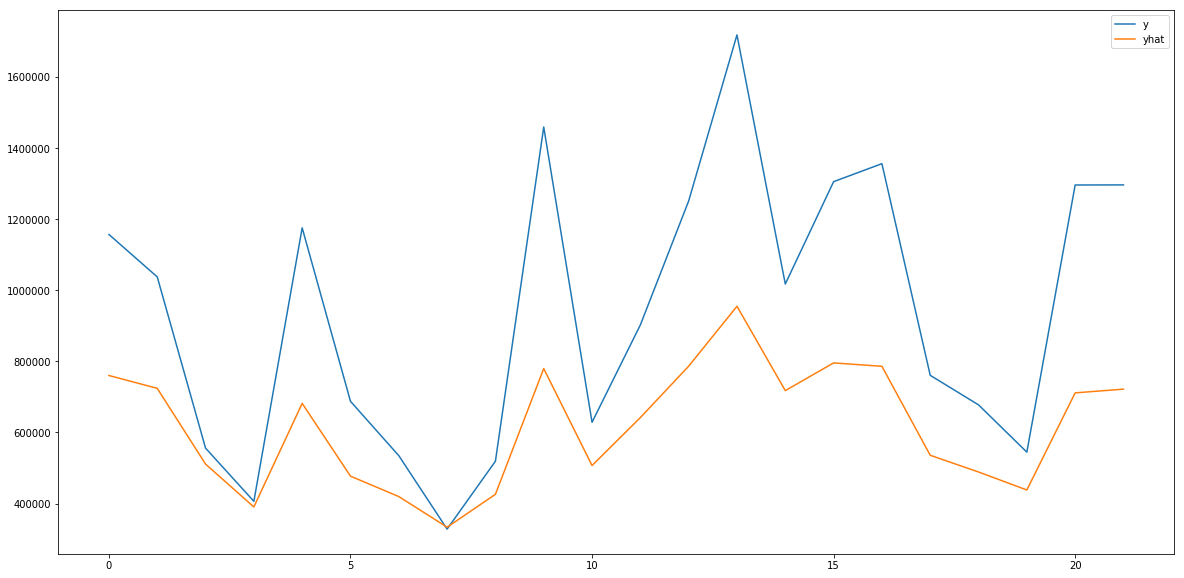

In [48]:
pyplot.show()